# All_News Dataset EDA

### This note book is for the EDA of the all news dataset

### Import packages

In [1]:
import pandas as pd
import os
import sys
import time
#from multiprocessing import Pool, cpu_count


### Add the folder "Clean" to the system path

In [2]:
# Add ../src to Python path
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../src'))
sys.path.insert(0, project_root)

# Import the parse config function to parse the .toml file
from utils.config_tool import parse_config

from engine.clean import clean_All_news as cc
from engine.ingestion import ingest_All_news as ii

### Parse the configuration .toml file

In [3]:
config_file = "../config/predict_stock_w_news.toml"
config = parse_config(config_file)

### Load the dataset

Since the dataset is too big (~8 Gb). So for the EDA use, we will first preprocess this data set, drop the full article columns, and leave only the word counts.

In [ ]:
# Define the preprocess function

def preprocess_custom(df, columns_to_drop, subset, publishers):
    df = cc.drop_columns(df, columns_to_drop)
    # Drop rows where 'article' is NaN
    cc.drop_null_article(df, subset)
    # Select the publishers
    df = cc.select_publishers(df, publishers)
    # tokenize the article
    df['token'] = df['article'].apply(cc.get_tokenized_words_with_no_punctuation)
    # Get the word count
    df['word_count'] = df['token'].apply(len)
    # Filter the articles based on word count
    df = df[(df['word_count'] > 100) & (df['word_count'] < 1000)]
    # Drop the article column
    df = df.drop('article', axis=1)
    # Remove stop words
    df['token'] = df['token'].apply(cc.remove_stop_words)
    
    return df


In [ ]:
# Loading the function
EDA_chunks = []
i = 0
start = time.time()
t0 = start
try:
    local_path = os.path.join(config['info']['local_data_path'], 'data_raw', config['news_ingestion']['input']['all_news_file'])
    for chunk in pd.read_csv(local_path, chunksize=10000):
        # Preprocess the chunk
        processed_chunk_EDA = preprocess_custom(chunk, config['news_ingestion']['input']['columns_to_drop'], config['news_ingestion']['input']['subsets_dropna'],config['news_ingestion']['input']['publisher'])[['date','section','publication', 'word_count']]
        EDA_chunks.append(processed_chunk_EDA)
        t1 = time.time()
        print(f'Processed {i} chunks in {t1 - t0} seconds')
        t0 = t1
        i += 1
except Exception as e:
    print(f'Error processing EDA data: {str(e)}')
    
    # Concatenate the processed chunks
processed_EDA = pd.concat(EDA_chunks)
end = time.time()
print(f'Total time: {end - start} seconds')

### Save to .csv

In [ ]:
# Save to the local path
save_path = os.path.join(config['info']['local_data_path'], 'data_raw', config['news_ingestion']['input']['eda_all_news_file'])
processed_EDA.to_csv(save_path, index=False)

## Explainatory data analysis

In [4]:
save_path = os.path.join(config['info']['local_data_path'], 'data_raw', config['news_ingestion']['input']['eda_all_news_file'])
processed_EDA = pd.read_csv(save_path)

processed_EDA.head()

,date,section,publication,word_count
0,2016-10-07 21:26:46,NaN,Business Insider,257
1,2019-06-27 00:00:00,World News,Reuters,372
2,2019-06-17 00:00:00,Financials,Reuters,128
3,2019-06-23 00:00:00,World News,Reuters,336
4,2016-05-18 13:00:06,NaN,Vox,147


## We look at the time

In [5]:
import matplotlib.pyplot as plt

import seaborn as sns


In [6]:
# Round the time to the nearest day
Date = pd.to_datetime(processed_EDA['date'], format='mixed').dt.date
date_counts = Date.value_counts()
date_counts.describe()
print(date_counts[date_counts <= 100].index)


Index([2020-04-01, 2020-04-02], dtype='object', name='date')


In [7]:
print(Date.describe())
print(f"The data starts from {Date.min()} to {Date.max()}")

count        1913509
unique          1554
top       2020-03-12
freq            2710
Name: date, dtype: object
The data starts from 2016-01-01 to 2020-04-02


In [ ]:
# The date where the number of articles is smaller than 70
processed_EDA['date'] = pd.to_datetime(processed_EDA['date'], format='mixed')
low_count_mask = processed_EDA['date'].dt.date.isin(date_counts[date_counts <= 70].index)
filtered_df = processed_EDA[low_count_mask]

print(f"Found {len(filtered_df)} articles with low counts")
print(filtered_df)

Found 1 articles with low counts
              date section    publication  word_count
1913469 2020-04-02     NaN  Buzzfeed News         373


Only the end day have the number of articles less than 50. So for the date between 2016-01-01 and 2020-04-01, there are at least 50 articles a day, which is a descent number.

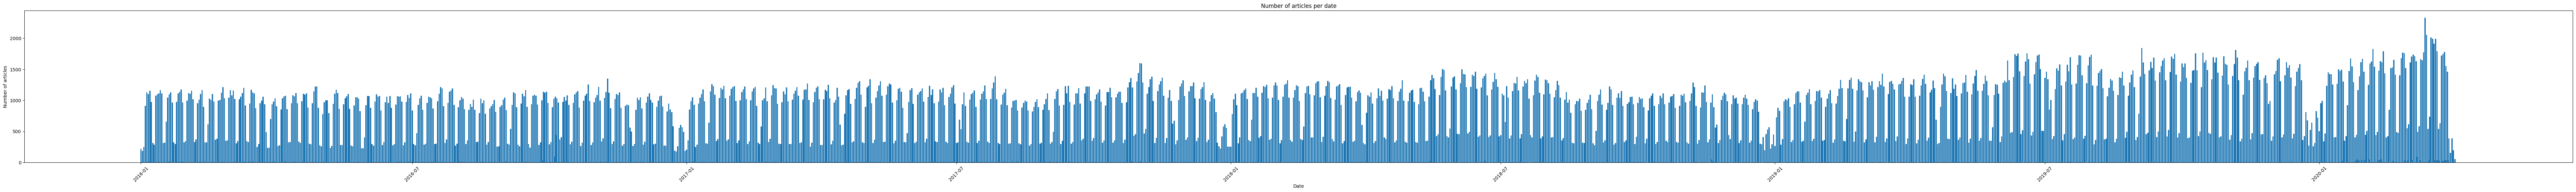

In [14]:
# Plot the number of articles per date
plt.figure(figsize=(100, 6))

plt.bar(processed_EDA['date'].value_counts().index, processed_EDA['date'].value_counts().values)

plt.title('Number of articles per date')

plt.xlabel('Date')
plt.ylabel('Number of articles')

plt.xticks(rotation=45)

plt.show()

## Now we look at the lable:

In [15]:
print(processed_EDA['section'].value_counts())
print(processed_EDA['section'].value_counts().describe())

section
World News                                                               90122
Business News                                                            86933
Wires                                                                    49287
politics                                                                 43350
Intel                                                                    36580
                                                                         ...  
parents-monitoring-teenagers-online-and-mostly-getting-it-right              1
please-read-my-book-unless-youre-a-friend-of-my-sons                         1
the-lessons-of-winter-break-protect-playtime-downtime-and-family-time        1
six-steps-to-teaching-children-about-the-stock-market                        1
hillary-clinton-bernie-sanders-magic-wand                                    1
Name: count, Length: 5517, dtype: int64
count     5517.000000
mean       225.199384
std       2389.271719
min          1.00

Looks like over 75% of the lables the number of articles are less than 3. So we will filter these lables.

In [16]:
# Filtering the sections with less than 1000 articles
sections = processed_EDA['section'].value_counts()
sections = sections[sections > 1000]
sections = sections.index
filtered_lable = processed_EDA[processed_EDA['section'].isin(sections)]['section']

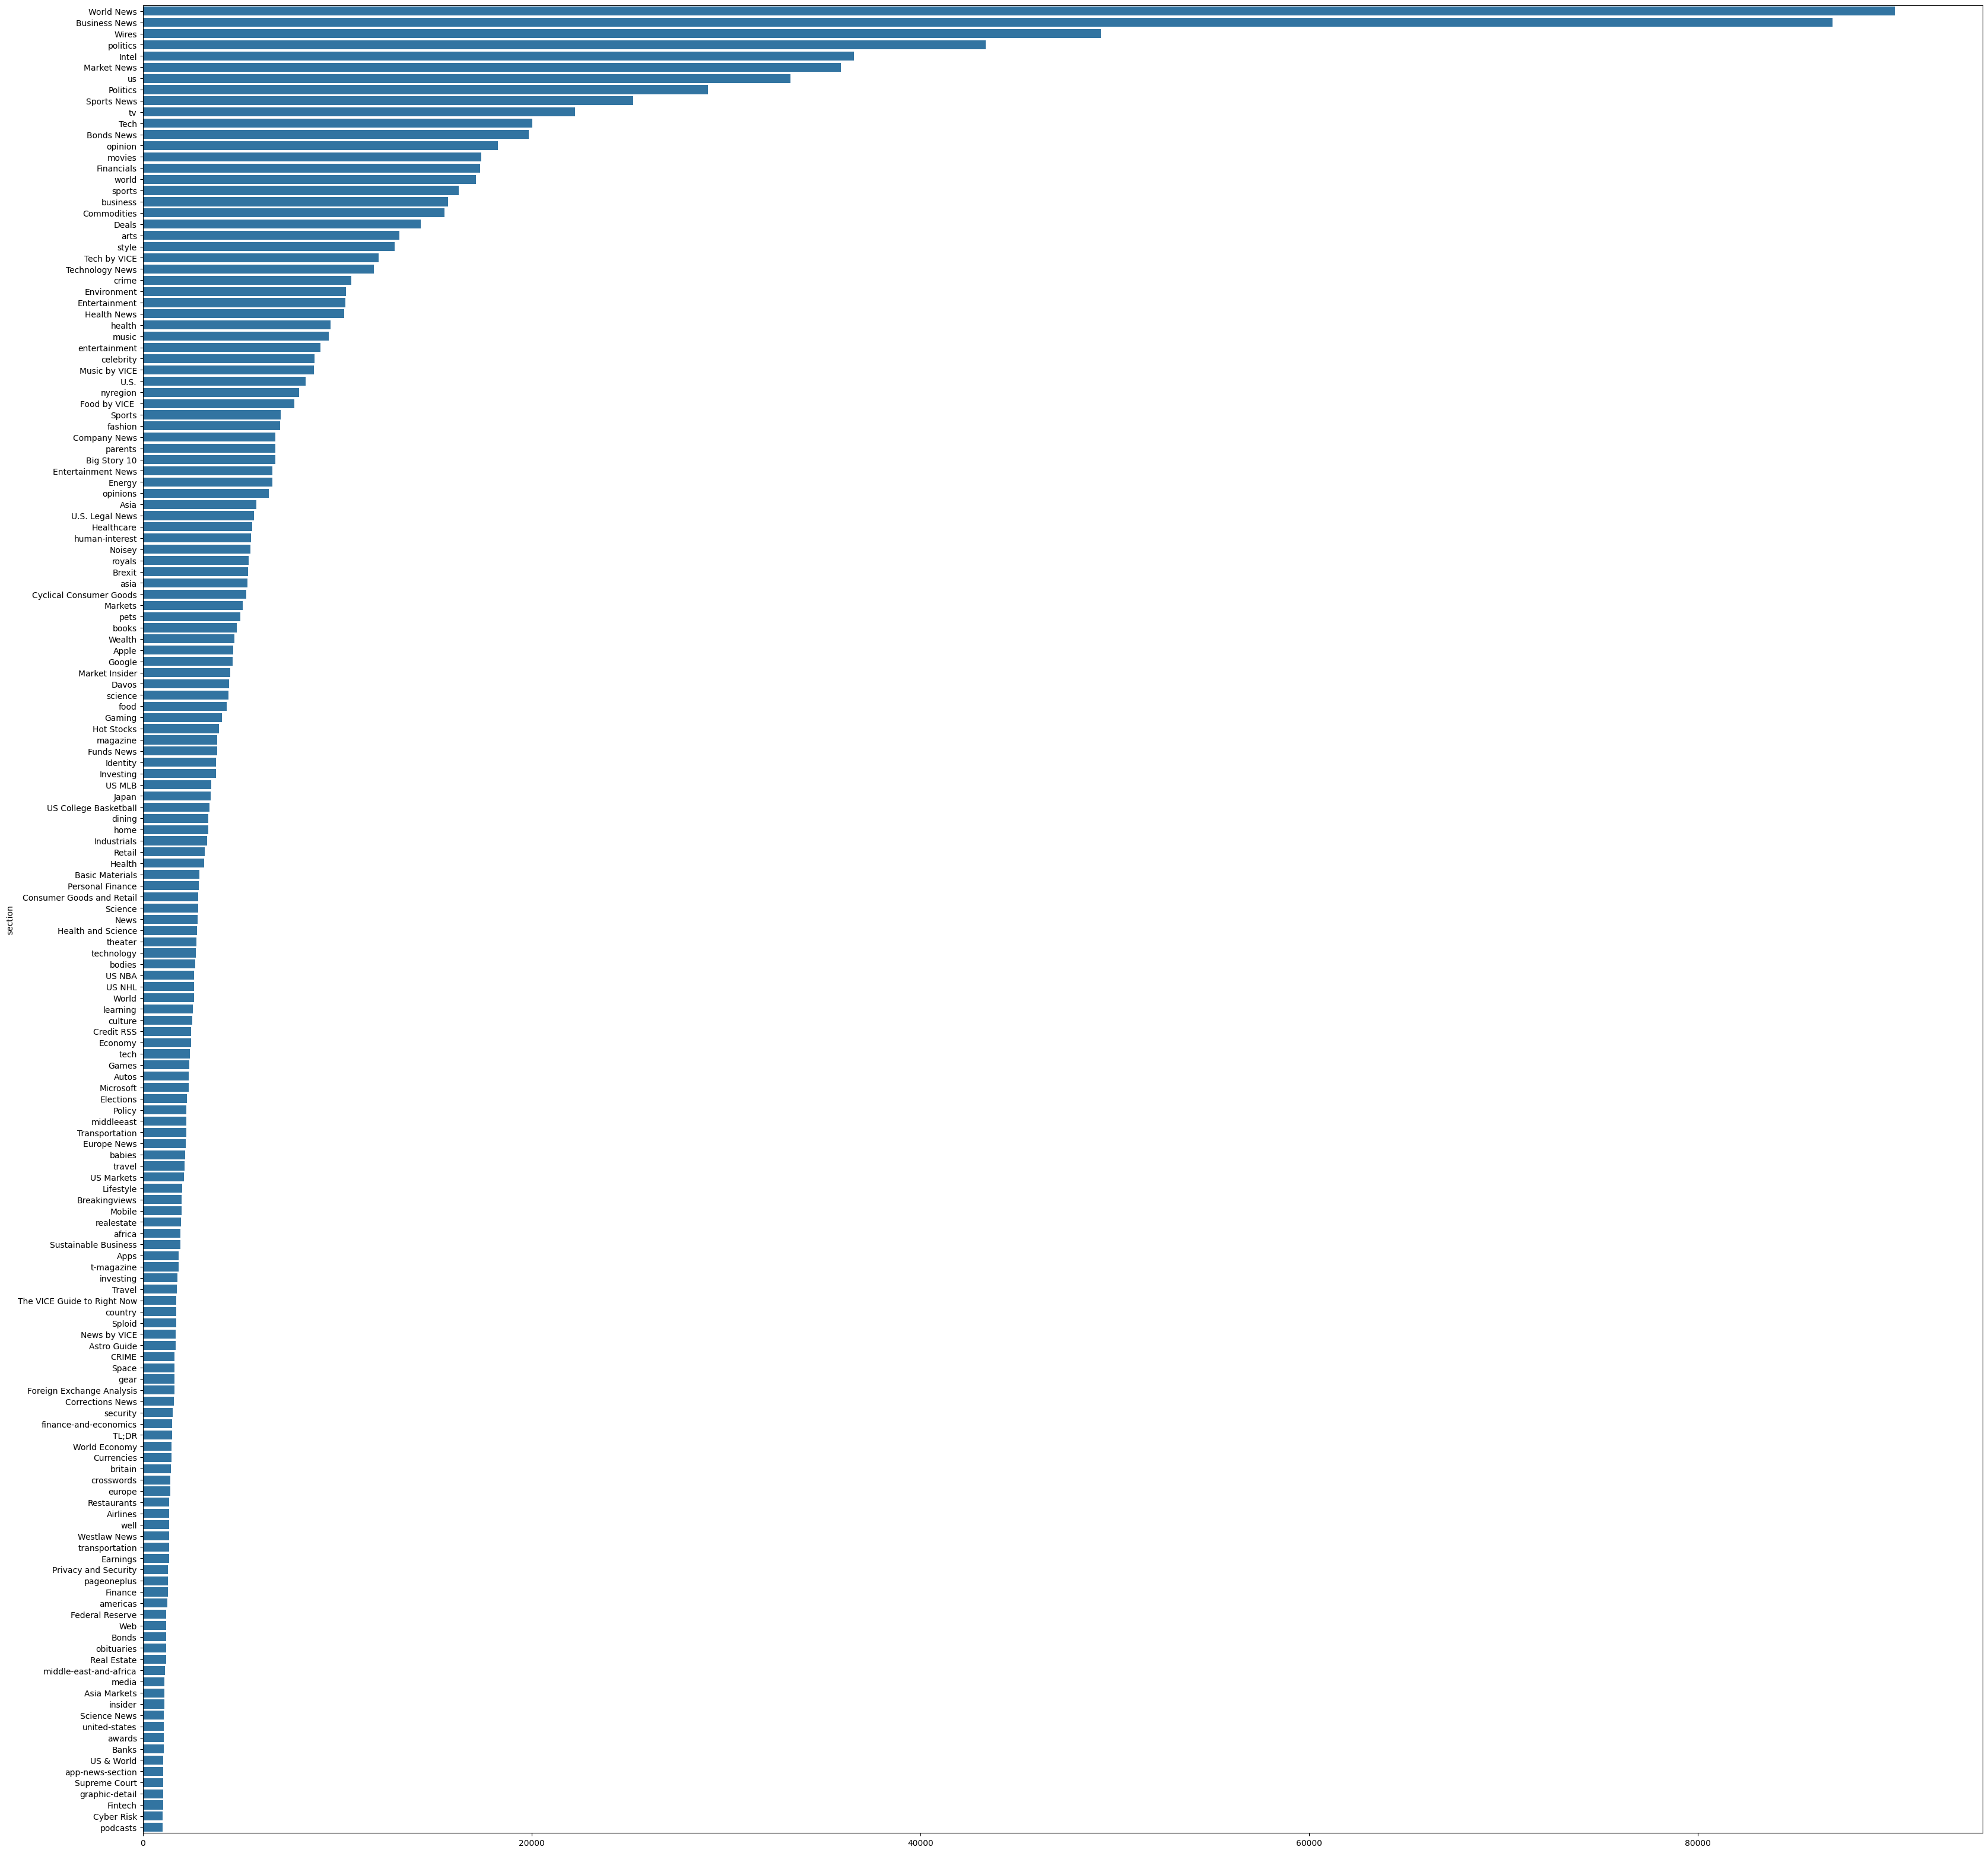

In [17]:
plt.figure(figsize=(40,40))

sns.barplot(y=filtered_lable.value_counts().index, x=filtered_lable.value_counts().values)

plt.yticks(rotation = 0, fontsize = 10)

plt.show()

And a lot of the news are without lables:

In [18]:
processed_EDA['section'].isna().sum()
print(f"The percentage of missing values in the section column: {processed_EDA['section'].isna().sum()/len(processed_EDA)*100}%")

The percentage of missing values in the section column: 35.07085673493043%


So it is better not to work on the label directly.

## Now we look at the publishers:

In [19]:
# Describe the publisher column
print(processed_EDA['publication'].value_counts())
print(processed_EDA['publication'].value_counts().sum())
print(processed_EDA['publication'].isna().sum())

publication
Reuters               531763
CNBC                  199821
The Hill              175375
The New York Times    147182
People                127169
CNN                   102466
Mashable               85063
Refinery 29            79042
Vice                   68973
TechCrunch             46330
The Verge              44100
Business Insider       43688
Axios                  37516
TMZ                    37498
Politico               34169
Vox                    27239
Gizmodo                23557
Buzzfeed News          22264
Fox News               18398
Economist              17999
Wired                  12821
Vice News              11343
Hyperallergic           8885
New Republic            7011
New Yorker              2375
Washington Post         1462
Name: count, dtype: int64
1913509
0


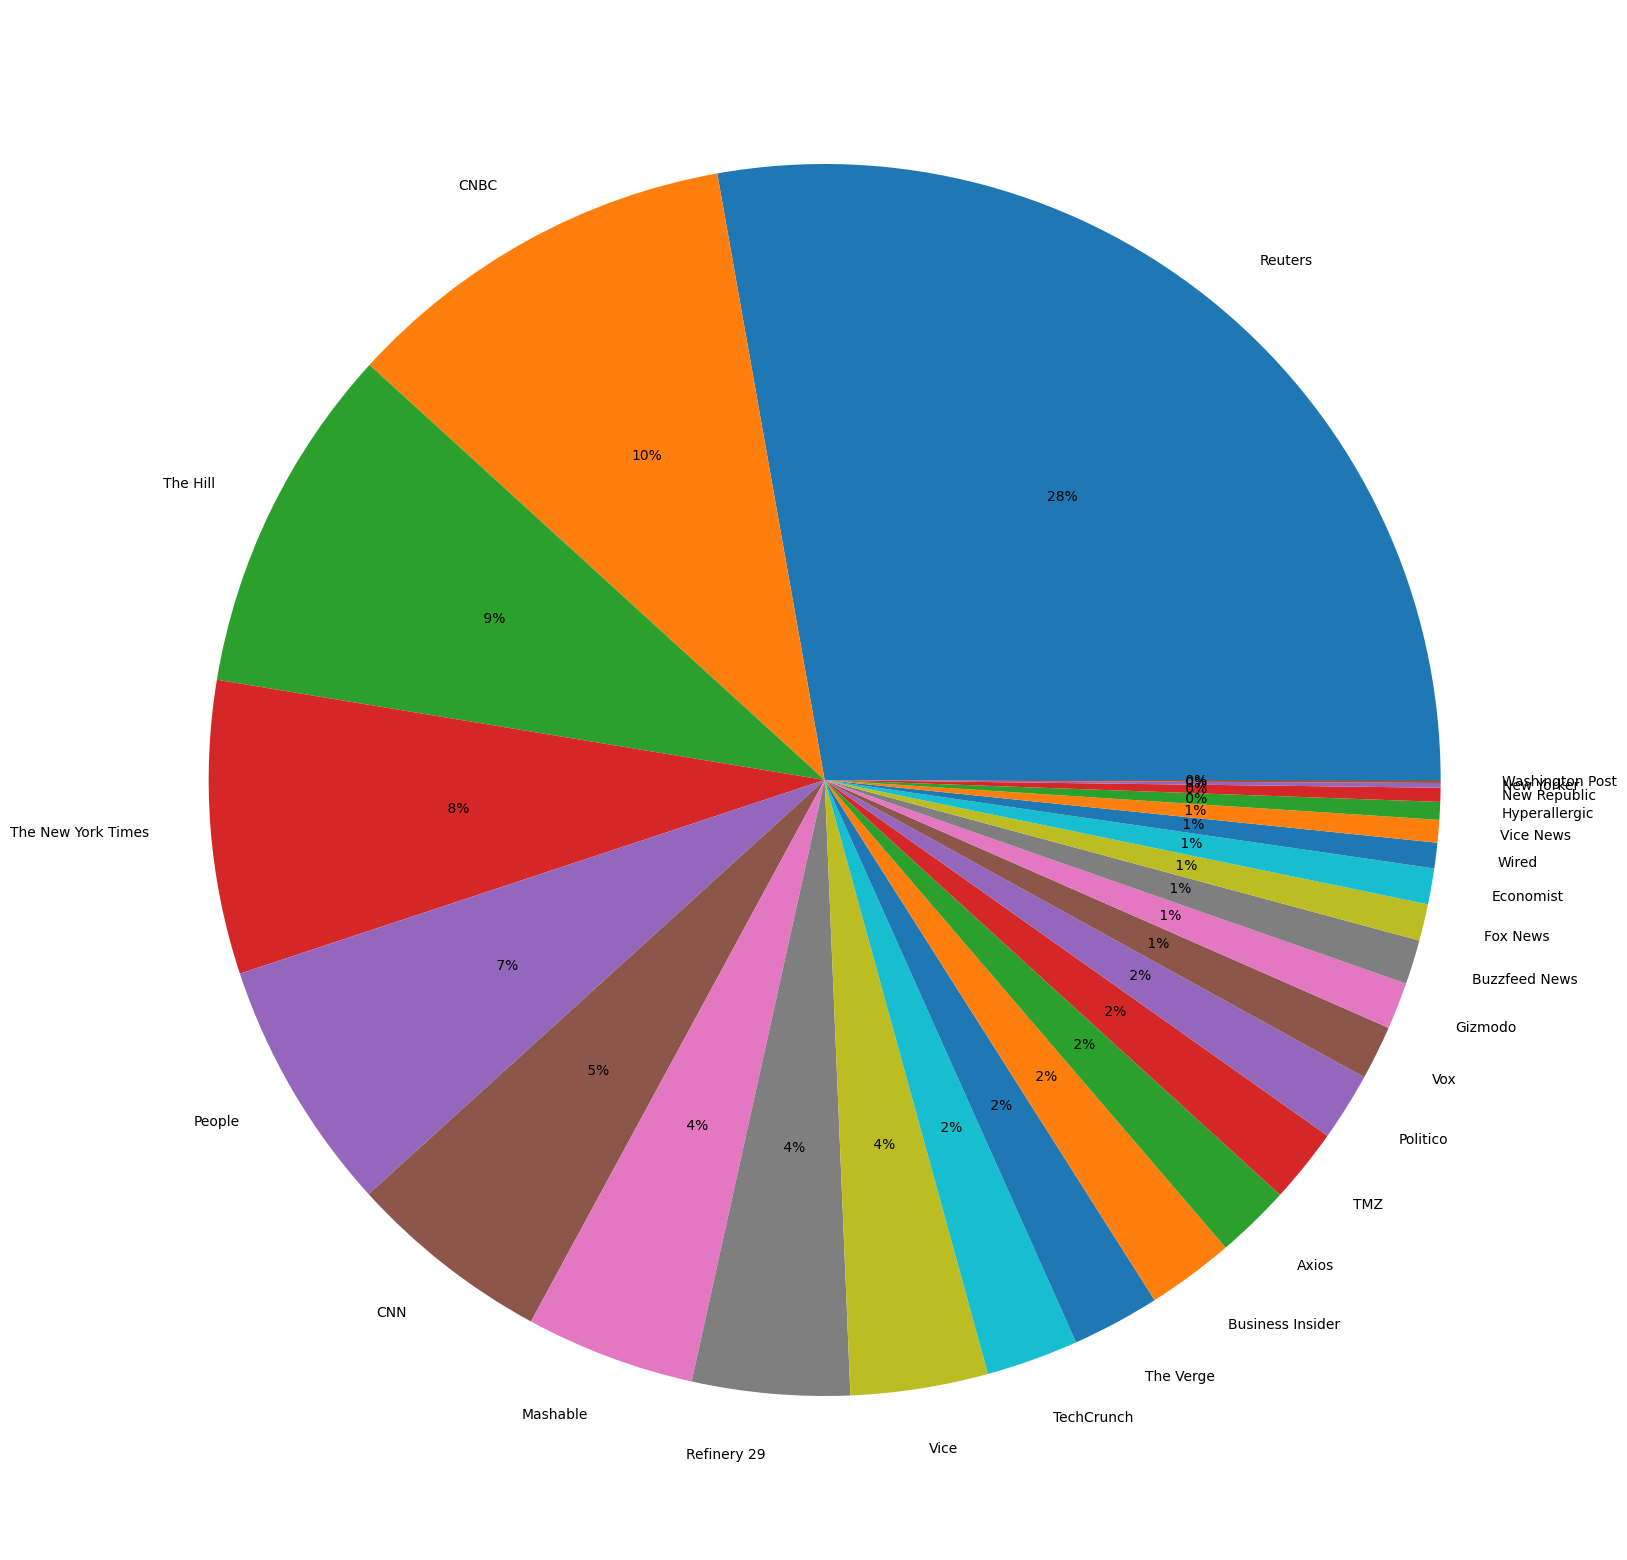

In [20]:
plt.figure(figsize=(20,20))

plt.pie(processed_EDA['publication'].value_counts().values, autopct='%2.0f%%', 
                labels=processed_EDA['publication'].value_counts().index)


plt.show()